<a href="https://colab.research.google.com/github/vinayykkumar/Visionary-Advanced-Image-Recognition-for-the-Next-Era_Infosys_Internship_Oct2024/blob/Shyam/Visionary2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import os

Loading and visualizing dataset...
Found 2350 files belonging to 4 classes.


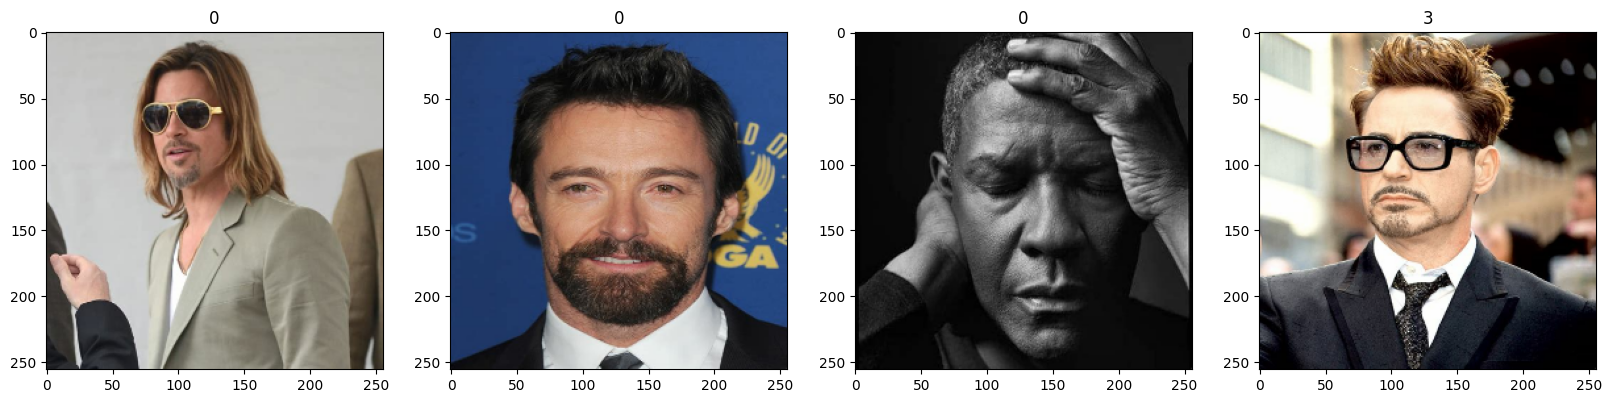

Preprocessing dataset...
Training data shape: (2350, 256, 256, 1)
Training labels shape: (2350,)


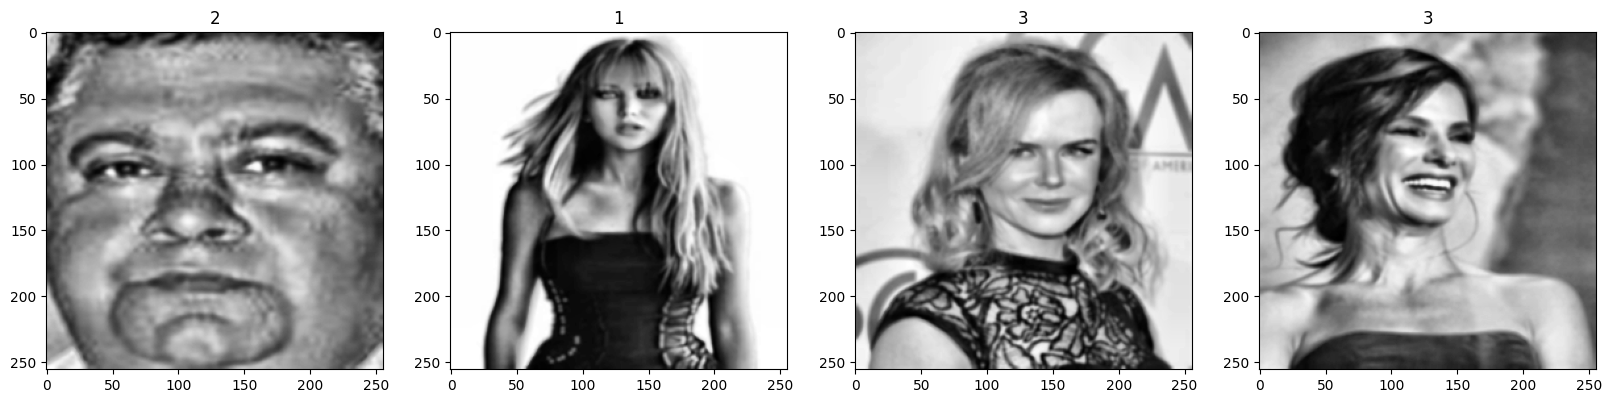

In [4]:
import tensorflow as tf
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Path to the dataset
data_dir = '/content/drive/MyDrive/actors_dataset/Indian_actors_faces'  # Replace with your dataset path

# 1. Visualize the Dataset
print("Loading and visualizing dataset...")

# Load the dataset and organize images by class (subfolder names as class labels)
data = tf.keras.utils.image_dataset_from_directory(data_dir)

# Convert the dataset into a NumPy iterator
data_iterator = data.as_numpy_iterator()

# Fetch a batch of images and labels
batch = data_iterator.next()

# Visualize the first 4 images in the batch
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):  # Show first 4 images
    ax[idx].imshow(img.astype(int))  # Convert to int for proper display
    ax[idx].title.set_text(batch[1][idx])  # Display class label as title
plt.show()

# 2. Preprocessing Function
def preprocess_image(image, size=(256, 256)):
    """Resize, normalize, and apply preprocessing to an image."""
    image = cv2.resize(image, size)  # Resize the image
    image = cv2.GaussianBlur(image, (5, 5), 0)  # Apply Gaussian blur
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # Ensure the image is 8-bit unsigned before applying CLAHE
    image = image.astype(np.uint8) # This line has been added
    image = clahe.apply(image)  # Apply CLAHE for contrast enhancement
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return np.expand_dims(image, axis=-1)  # Add channel dimension

# 3. Apply Preprocessing to the Dataset
def preprocess_dataset(dataset, size=(256, 256)):
    """Preprocess an entire dataset using the preprocessing function."""
    preprocessed_images = []
    labels = []
    for images, lbls in dataset:
        for img, lbl in zip(images, lbls):
            # Preprocess each image
            preprocessed_img = preprocess_image(img.numpy(), size)
            preprocessed_images.append(preprocessed_img)
            labels.append(lbl.numpy())
    return np.array(preprocessed_images), np.array(labels)

# Preprocess training and validation datasets
print("Preprocessing dataset...")
train_images, train_labels = preprocess_dataset(data)

# Display dataset shape after preprocessing
print(f"Training data shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")

# Optional: Visualize a few preprocessed images
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(train_images[:4]):  # Show first 4 preprocessed images
    ax[idx].imshow(img.squeeze(), cmap='gray')  # Show as grayscale
    ax[idx].title.set_text(train_labels[idx])  # Display class label as title
plt.show()


Scale data

In [5]:
# 2. Dataset Loading Function
def load_data(data_dir, size=(256, 256)):
    """Load images and labels from a directory."""
    images, labels = [], []
    class_names = sorted(os.listdir(data_dir))  # Sort classes alphabetically
    class_indices = {class_name: i for i, class_name in enumerate(class_names)}  # Map classes to integers

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = cv2.imread(image_path)
            if image is not None:
                preprocessed_image = preprocess_image(image, size)
                images.append(preprocessed_image)
                labels.append(class_indices[class_name])

    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')
    return images, labels


In [6]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_and_save(data, labels, output_dir, class_names, size=(224, 224), total_augmented_images=300):
    """
    Augments images and saves them to disk.
    Ensures a total of `total_augmented_images` augmented images across all classes.
    """

    # Data augmentation configuration
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Initialize lists for augmented data and labels
    augmented_data = []
    augmented_labels = []

    # Calculate how many augmented images to generate per original image
    images_per_class = len(data) // len(class_names)
    augment_per_image = total_augmented_images // len(data)

    print("Starting augmentation...")
    for i, (image, label) in enumerate(zip(data, labels)):
        # Decode the one-hot label to get the class name
        class_name = class_names[np.argmax(label)]  # Assuming labels are one-hot encoded
        label_dir = os.path.join(output_dir, class_name)
        os.makedirs(label_dir, exist_ok=True)

        # Resize the image to the target size
        image_resized = cv2.resize(image, size)

        # Ensure the image has a channel dimension (even if grayscale)
        if image_resized.ndim == 2:  # Check if grayscale
            image_resized = np.expand_dims(image_resized, axis=-1)

        # Expand dimensions to create a batch of size 1
        image_expanded = np.expand_dims(image_resized, axis=0)
        counter = 0

        # Augment images and save them
        for batch in datagen.flow(image_expanded, batch_size=1):
            # Save augmented image
            save_path = os.path.join(label_dir, f"{class_name}_aug_{i}_{counter}.jpg")
            cv2.imwrite(save_path, (batch[0] * 255).astype(np.uint8))  # Convert to [0-255] before saving

            # Append to augmented data and labels
            augmented_data.append(batch[0])  # Add the augmented image
            augmented_labels.append(label)  # Add corresponding label
            counter += 1

            # Stop after generating the specified number of augmentations per image
            if counter >= augment_per_image:
                break

        # Stop augmentation early if total images reached
        if len(augmented_data) >= total_augmented_images:
            break

    print("Augmentation complete.")
    return np.array(augmented_data), np.array(augmented_labels)

# Example Usage:
# Assuming `train_images` and `train_labels` are already preprocessed
output_directory = '/content/augmented_dataset'  # Directory to save augmented data
class_names = ['Class1', 'Class2']  # Replace with your actual class names

# Generate augmented data and save to disk
augmented_images, augmented_labels = augment_and_save(
    train_images, train_labels, output_directory, class_names, total_augmented_images=300
)

# Print the shape of augmented data
print(f"Augmented Images Shape: {augmented_images.shape}")
print(f"Augmented Labels Shape: {augmented_labels.shape}")



Starting augmentation...
Augmentation complete.
Augmented Images Shape: (300, 224, 224, 1)
Augmented Labels Shape: (300,)


In [7]:
import tensorflow as tf # Importing the TensorFlow library
data_dir = '/content/drive/MyDrive/actors_dataset/Indian_actors_faces' # Replace with the correct path

data = tf.keras.utils.image_dataset_from_directory(data_dir)
data = data.map(lambda x,y: (x/255, y))  # Scaling the Image Data,Scaling to [0, 1]
data.as_numpy_iterator().next() # Retrieving a  batch of data

Found 2350 files belonging to 4 classes.


(array([[[[2.01508880e-01, 2.44646147e-01, 1.89744174e-01],
          [2.01508880e-01, 2.44646147e-01, 1.89744174e-01],
          [1.97587311e-01, 2.44646147e-01, 1.89744174e-01],
          ...,
          [2.54396439e-01, 2.58318007e-01, 2.26945460e-01],
          [2.62747884e-01, 2.66669452e-01, 2.35296905e-01],
          [2.76018679e-01, 2.79940248e-01, 2.48567715e-01]],
 
         [[1.96683511e-01, 2.39820778e-01, 1.84918806e-01],
          [1.96683511e-01, 2.39820778e-01, 1.84918806e-01],
          [1.92761943e-01, 2.39820778e-01, 1.84918806e-01],
          ...,
          [2.54901975e-01, 2.58823544e-01, 2.27450982e-01],
          [2.59260803e-01, 2.63182372e-01, 2.31809825e-01],
          [2.67271757e-01, 2.71193326e-01, 2.39820778e-01]],
 
         [[1.92156866e-01, 2.35294119e-01, 1.80392161e-01],
          [1.92156866e-01, 2.35294119e-01, 1.80392161e-01],
          [1.88235298e-01, 2.35294119e-01, 1.80392161e-01],
          ...,
          [2.59329051e-01, 2.63250619e-01, 2.3187

Split data

In [8]:
# Define the split ratios
train_split = 0.7  # 70% for training
val_split = 0.2    # 20% for validation
test_split = 0.1   # 10% for testing

# Total number of samples
total_size = len(data)

# Calculate the number of samples for each split
train_size = int(total_size * train_split)
val_size = int(total_size * val_split)

# Split the dataset
train = data.take(train_size)  # Take the first 70% for training
val = data.skip(train_size).take(val_size)  # Skip training samples and take the next 20% for validation
test = data.skip(train_size + val_size)  # Skip training + validation samples and use the remaining 10% for testing

# Verify the splits
print(f"Training Size: {len(list(train))} batches")
print(f"Validation Size: {len(list(val))} batches")
print(f"Testing Size: {len(list(test))} batches")


Training Size: 51 batches
Validation Size: 14 batches
Testing Size: 9 batches


Build Deep Learning Model

In [9]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential, Model # Importing Model from tensorflow.keras.models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.applications import VGG16

# 1. Load or Create Training and Validation Data
X_train = np.random.rand(100, 256, 256, 3)  # Example training data (replace with real data)
y_train = np.random.randint(0, 2, size=100)  # Binary labels (0 or 1)
X_val = np.random.rand(20, 256, 256, 3)  # Example validation data
y_val = np.random.randint(0, 2, size=20)

# 2. Create TensorFlow datasets
train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
val = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)


# Use VGG16 as the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a custom classification head
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(len(class_names), activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Define the Model
model = Sequential()

# Convolutional Layers with BatchNormalization and MaxPooling2D
model.add(Conv2D(16, (3, 3), strides=1, activation='relu', input_shape=(256, 256, 3)))  # First Conv2D layer
model.add(MaxPooling2D())  # Reduces spatial dimensions
model.add(BatchNormalization())  # Normalizes feature maps

#model.add(Conv2D(32, (3, 3), strides=1, activation='relu'))  # Second Conv2D layer
#model.add(MaxPooling2D())
#model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))  # Third Conv2D layer
model.add(MaxPooling2D())
model.add(BatchNormalization())  # Normalize feature maps

# Use GlobalAveragePooling2D to reduce spatial dimensions and summarize features
model.add(GlobalAveragePooling2D())

# Fully Connected Layers
model.add(Dense(128, activation='relu'))  # Fully connected dense layer
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# 4. Define Optimizer with Custom Learning Rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# 5. Compile the Model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 6. TensorBoard Callback
logdir = 'logs'  # Path to save logs for TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# 7. Train the Model
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

# 8. Display Model Summary (Optional)
model.summary()

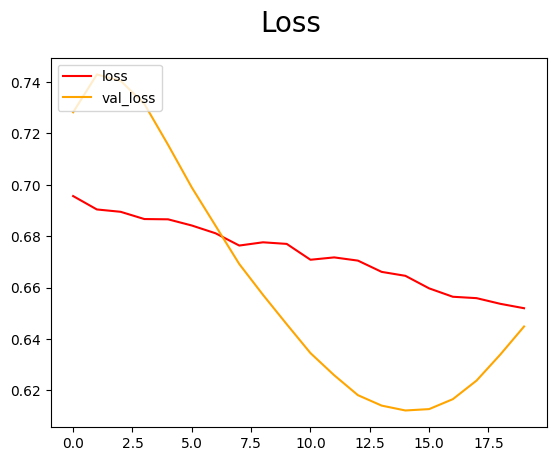

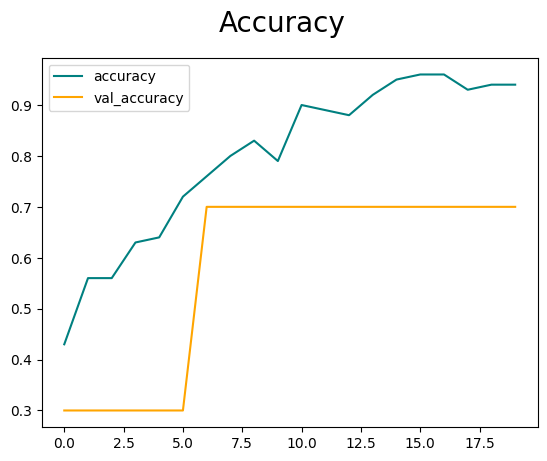

In [ ]:
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib and alias it as plt

fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")

plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

# Assuming you have a test dataset similar to train and validation
X_test = np.random.rand(20, 256, 256, 3)    # Example test data with 20 samples
y_test = np.random.randint(0, 2, size=20)    # Example test labels (0 or 1)

# Create TensorFlow dataset for testing
test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Now you can evaluate the model
test_loss, test_accuracy = model.evaluate(test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.6000 - loss: 0.7870
Test Loss: 0.786995530128479
Test Accuracy: 0.6000000238418579


Test

Selected image: /content/drive/MyDrive/actors_dataset/Indian_actors_faces/Label 1/098_5cb67f9d.jpg


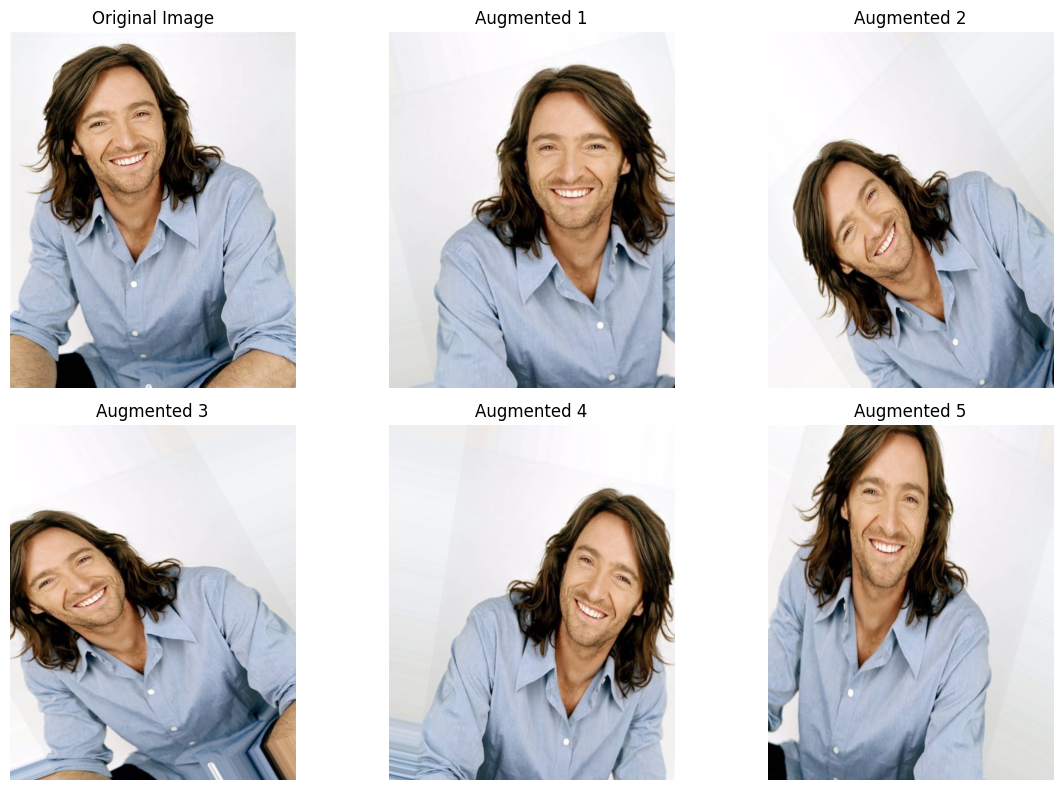

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

# Define the directory containing the images
image_dir = "/content/drive/MyDrive/actors_dataset/Indian_actors_faces/Label 1"

# List all files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Check if there are images in the directory
if len(image_files) > 0:
    # Select a random image
    image_file = np.random.choice(image_files)
    image_path = os.path.join(image_dir, image_file)
    print(f"Selected image: {image_path}")

    # Load the image
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for compatibility
        img_array = img_to_array(img)              # Convert to array
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Initialize the ImageDataGenerator
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # Generate augmented images
        aug_iter = train_datagen.flow(img_array, batch_size=1)

        # Plot original image and augmented versions
        fig, axes = plt.subplots(2, 3, figsize=(12, 8))

        # Display original image
        axes[0, 0].imshow(img / 255)  # Normalize for Matplotlib
        axes[0, 0].set_title("Original Image")
        axes[0, 0].axis('off')

        # Generate and display augmented images
        for i in range(1, 6):  # Start from index 1 because 0 is for the original image
            augmented_img = next(aug_iter)  # Get the next augmented image
            axes[i // 3, i % 3].imshow(augmented_img[0])  # Use [0] to get the image from the batch
            axes[i // 3, i % 3].set_title(f"Augmented {i}")
            axes[i // 3, i % 3].axis('off')

        plt.tight_layout()
        plt.show()

    else:
        print(f"Error: Could not load the selected image file: {image_path}")

else:
    print(f"Error: No images found in the directory: {image_dir}")

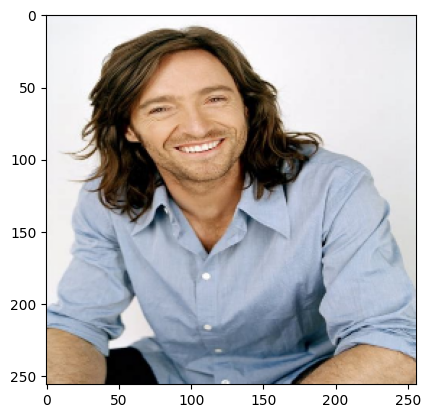

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Predicted class is Happy


In [ ]:
import tensorflow as tf # Import tensorflow at the beginning of the cell
import matplotlib.pyplot as plt
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()
yhat = model.predict(np.expand_dims(resize/255, 0))
if yhat > 0.5:
    print(f'Predicted class is Happy')
else:
    print(f'Predicted class is Sad')

In [ ]:
# Save the model in the HDF5 format
model.save('cnn_model.h5')

# OR save in the native Keras format
model.save('cnn_model.keras')

# OR to export the model, you can use this
model.export('cnn_model') #Make sure you import tf.saved_model

Saved artifact at 'cnn_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_106')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134175433057280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134175649286096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134175623170000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134175623169120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134175649300000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134175623169296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134175623177216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134175623175280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134175623177920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134175623182320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134175623182496: 

In [ ]:
# Predict the class probabilities
# Get images and labels from the test dataset
from sklearn.metrics import accuracy_score # Import accuracy_score

test_images = []
test_labels = []
for images, labels in test:
    test_images.extend(images.numpy())
    test_labels.extend(labels.numpy())

test_images = np.array(test_images)  # Convert to NumPy array
predictions = model.predict(test_images)

# Convert probabilities to class labels (for multi-class classification)
predicted_classes = np.argmax(predictions, axis=1)

# Since test_labels are NOT one-hot encoded, directly use them:
true_classes = np.array(test_labels) # Convert test_labels to NumPy array

# If you intend to calculate accuracy, etc., you can still use:
# from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Accuracy: {accuracy}") # Removed extra space before print statement


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
Accuracy: 0.4
